# Homework 3

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as stats
import seaborn as sns
import pymc3 as pm
import arviz as az

import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)  #suppress Arviz warnings

from sklearn import preprocessing

from causalgraphicalmodels import CausalGraphicalModel
import daft

In [2]:
d = pd.read_csv("Data/foxes.csv", sep=";", header=0)
d.head()

,group,avgfood,groupsize,area,weight
0,1,0.37,2,1.09,5.02
1,1,0.37,2,1.09,2.84
2,2,0.53,2,2.05,5.33
3,2,0.53,2,2.05,6.07
4,3,0.49,2,2.12,5.85


In [3]:
scaler = preprocessing.StandardScaler()
std = scaler.fit_transform(d[["avgfood", "groupsize", "area", "weight"]])
std_df = pd.DataFrame(std, columns=["avgfood_s", "groupsize_s", "area_s", "weight_s"])
d2 = pd.concat([d, std_df], axis=1)

## Initial DAG

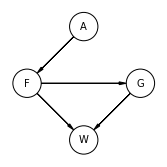

In [4]:
dag0 = CausalGraphicalModel(
    nodes=["A", "F", "G", "W"]
        , edges=[("A", "F"), ("F", "G"), ("F", "W"), ("G", "W")]
)
pgm = daft.PGM()
# coordinates are column, row
coordinates = {"A": (1, 0), "F": (0, 1), "G": (2, 1), "W": (1,2)}
for node in dag0.dag.nodes:
    pgm.add_node(node, node, *coordinates[node])
for edge in dag0.dag.edges:
    pgm.add_edge(*edge)
pgm.render()
plt.gca().invert_yaxis()

## Question 1

>Use a model to infer the total causal influence of area on weight. Would
increasing the area available to each fox make it heavier (healthier)? You
might want to standardize the variables. Regardless, use prior predictive
simulation to show that your model’s prior predictions stay within the possible
outcome range.

### DAG for question

Want total effect of area (A) on weight (W).  Condition on no other variables:

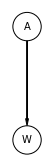

In [5]:
dag1 = CausalGraphicalModel(
    nodes=["A","W"]
        , edges=[("A", "W")]
)
pgm = daft.PGM()
# coordinates are column, row
coordinates = {"A": (1, 0), "W": (1,2)}
for node in dag1.dag.nodes:
    pgm.add_node(node, node, *coordinates[node])
for edge in dag1.dag.edges:
    pgm.add_edge(*edge)
pgm.render()
plt.gca().invert_yaxis()

### Linear model

In [6]:
with pm.Model() as q1mod:
    a = pm.Normal("a", 0, 1)  # should be close to zero for standardized variables
    b_area = pm.Normal("b_area", 0, 1)
    mu = a + b_area * d2["area_s"]
    sigma = pm.Exponential("sigma", 1)
    weight_s = pm.Normal("weight_s", mu, sigma, observed=d2["weight_s"])
    q1trace = pm.sample(1000, tune=1000)

WARNING (theano.gof.compilelock): Overriding existing lock by dead process '10488' (I am process '10172')
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, b_area, a]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 16 seconds.


In [7]:
az.summary(q1trace, kind="stats", round_to=2)

,mean,sd,hdi_3%,hdi_97%
a,-0.00,0.10,-0.19,0.18
b_area,0.02,0.10,-0.16,0.18
sigma,1.01,0.07,0.88,1.14


### Response to questions

The CI spans zero, so it is not clear that area has any main effect on weight.  Making area larger thus does not seem to make foxes larger.

### Prior predictive simulation

In [8]:
with q1mod:
    q1pps = pm.sample_prior_predictive(samples=30)

In [9]:
area_seq = np.linspace(d2["area_s"].min(), d2["area_s"].max(), 30)

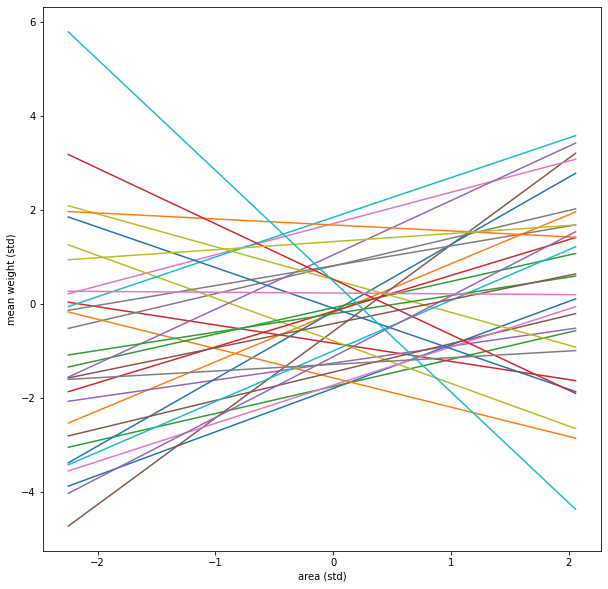

In [10]:
__, ax = plt.subplots(figsize=(10,10))
ax.set(xlabel="area (std)", ylabel="mean weight (std)")
for idx in range(len(q1pps["weight_s"])):
    plt.plot(area_seq, 
            q1pps["a"][idx] +
            q1pps["b_area"][idx] * area_seq, "-")

### Tighten up priors

In [11]:
with pm.Model() as q1mod2:
    a = pm.Normal("a", 0, 1)  # should be close to zero for standardized variables
    b_area = pm.Normal("b_area", 0, 0.5)
    mu = a + b_area * d2["area_s"]
    sigma = pm.Exponential("sigma", 1)
    weight_s = pm.Normal("weight_s", mu, sigma, observed=d2["weight_s"])
    q1traceb = pm.sample(1000, tune=1000)
    
    q1pps2 = pm.sample_prior_predictive(samples=30)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, b_area, a]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 13 seconds.


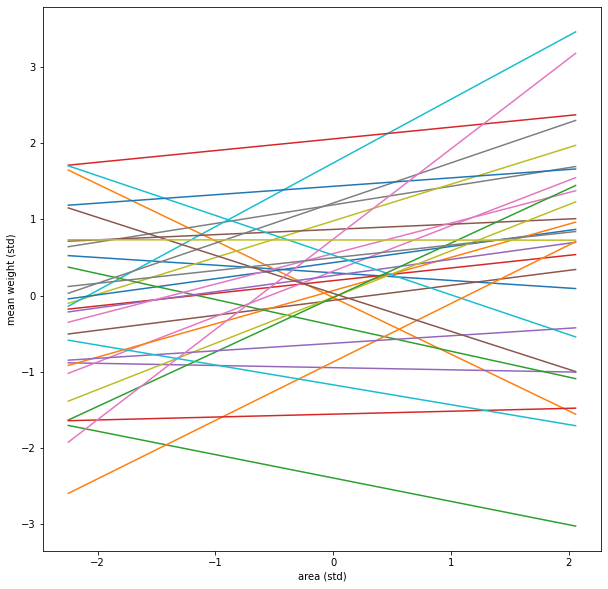

In [12]:
__, ax = plt.subplots(figsize=(10,10))
ax.set(xlabel="area (std)", ylabel="mean weight (std)")
for idx in range(len(q1pps2["weight_s"])):
    plt.plot(area_seq, 
            q1pps2["a"][idx] +
            q1pps2["b_area"][idx] * area_seq, "-")

## Question 2

>Now infer the causal impact of adding food (avgfood) to a territory.
Would this make foxes heavier? Which covariates do you need to adjust
for to estimate the total causal influence of food?

### DAG for question

Same idea: we want the total impact of food (F) on weight (W) without conditioning on any other variables.  This gives the direct effect of food on weight plus the indirect effect through group size in the initial DAG.

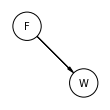

In [13]:
dag2 = CausalGraphicalModel(
    nodes=["F","W"]
        , edges=[("F", "W")]
)
pgm = daft.PGM()
# coordinates are column, row
coordinates = {"F": (0, 1), "W": (1,2)}
for node in dag2.dag.nodes:
    pgm.add_node(node, node, *coordinates[node])
for edge in dag2.dag.edges:
    pgm.add_edge(*edge)
pgm.render()
plt.gca().invert_yaxis()

In [14]:
with pm.Model() as q2mod1:
    a = pm.Normal("a", 0, 0.2)  # should be close to zero for standardized variables
    b_f = pm.Normal("b_f", 0, 0.5)
    mu = a + b_f * d2["avgfood_s"]
    sigma = pm.Exponential("sigma", 1)
    weight_s = pm.Normal("weight_s", mu, sigma, observed=d2["weight_s"])
    q2trace = pm.sample(1000, tune=1000)
    
    q2pps = pm.sample_prior_predictive(samples=30)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, b_f, a]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 13 seconds.


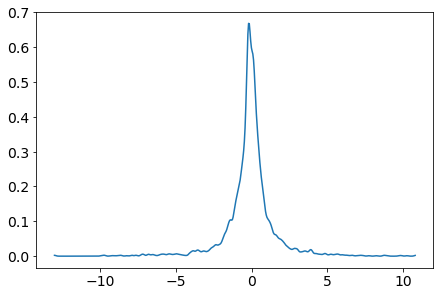

In [15]:
az.plot_kde(q2pps["weight_s"]);

In [16]:
az.summary(q2trace, kind="stats", round_to=2)

,mean,sd,hdi_3%,hdi_97%
a,0.00,0.09,-0.16,0.17
b_f,-0.02,0.10,-0.21,0.14
sigma,1.01,0.07,0.89,1.14


### Answers to questions

The total impact of food is small but apparently non-negligible.

**Update:** When I use Richard's tighter priors I get posteriors for b_f that straddle zero.

## Question 3

>Now infer the causal impact of group size. Which covariates do you need
to adjust for? Looking at the posterior distribution of the resulting model,
what do you think explains these data? That is, can you explain the estimates
for all three problems? How do they make sense together?

The DAG here is:

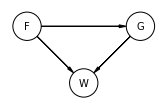

In [20]:
dag3 = CausalGraphicalModel(
    nodes=["F", "G", "W"]
        , edges=[("F", "W"), ("F", "G"), ("G", "W")]
)
pgm = daft.PGM()
# coordinates are column, row
coordinates = {"F": (0, 1), "G": (2, 1), "W": (1,2)}
for node in dag3.dag.nodes:
    pgm.add_node(node, node, *coordinates[node])
for edge in dag3.dag.edges:
    pgm.add_edge(*edge)
pgm.render()
plt.gca().invert_yaxis()

This implies that there is a "back door" from G to W through F.  This can be closed by conditioning on F:

In [21]:
with pm.Model() as q3mod1:
    a = pm.Normal("a", 0, 0.2)  # should be close to zero for standardized variables
    b_f = pm.Normal("b_f", 0, 0.5)
    b_gs = pm.Normal("b_gs", 0, 0.5)
    mu = a + b_f * d2["avgfood_s"] + b_gs * d2["groupsize_s"]
    sigma = pm.Exponential("sigma", 1)
    weight_s = pm.Normal("weight_s", mu, sigma, observed=d2["weight_s"])
    q3trace = pm.sample(1000, tune=1000)
    
    q3pps = pm.sample_prior_predictive(samples=30)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, b_gs, b_f, a]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 11 seconds.


In [22]:
az.summary(q3trace, kind="stats", round_to=2)

,mean,sd,hdi_3%,hdi_97%
a,0.00,0.08,-0.15,0.15
b_f,0.48,0.19,0.11,0.78
b_gs,-0.57,0.19,-0.90,-0.21
sigma,0.97,0.07,0.83,1.09


**Conclusion:** Group size has a negative impact on weight when we control for food.  So food may have a positive effect of weight, but also has a positive effect on group size, which has a negative effect on weight.  That is one reason why food washes out in Question 2.